<a href="https://colab.research.google.com/github/aitormorais/Qiskit/blob/main/Algoritmo_genetico_tsp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import itertools
import numpy as np
import time

In [ ]:
def generar_grafo(numero_ciudades):
  n = numero_ciudades # número de nodos
  G = nx.complete_graph(n) # grafo completo
  for (u, v) in G.edges():
      G.edges[u, v]['distancia'] = random.randint(1, 10) # peso aleatorio en la arista
  #if dibujar:# Dibujar el grafo
  pos = nx.circular_layout(G) # posición de los nodos en un círculo
  nx.draw(G, pos, with_labels=True) # dibujar el grafo con etiquetas de nodos
  labels = nx.get_edge_attributes(G, 'distancia') # obtener los pesos de las aristas
  nx.draw_networkx_edge_labels(G, pos, edge_labels=labels) # dibujar los pesos de las aristas
  return G,labels

In [ ]:
def crear_poblacion(numero_ciudades):
  viajes = []
  for i in range(numero_ciudades):
    viaje = list(range(numero_ciudades))
    random.shuffle(viaje)
    viajes.append(viaje)
  return viajes

obtener la distancia total del recorrido


In [ ]:
def distancia_entera(viaje,labels):
  suma = 0
  for pueblo in viaje:
    if pueblo == viaje[-1]:
      clave = (viaje[0],pueblo) if pueblo > viaje[0] else (pueblo,viaje[0])
      suma = suma +labels.get(clave, None)
    else:
      siguiente= viaje[viaje.index(pueblo)+1]
      clave = (pueblo,siguiente ) if siguiente > pueblo else (siguiente,pueblo)
      suma = suma +labels.get(clave, None)
  return suma


Almacenar distancia en un array

In [ ]:
def almacenar_dist(viajes,labels):
  recorridos=[]
  for v in viajes:
    recorridos.append(distancia_entera(v,labels))
  return recorridos

Cruce

In [ ]:
def crucePMX(padre1,padre2):
    # generamos los puntos de corte aleatorios
    primero = random.randint(0, len(padre2)-2)
    segundo = random.randint(primero+1, len(padre2)-1)
    # creamos los bloques de los padres
    bloque_padre2 = padre2[primero:segundo]
    # creamos los hijos
    hijo1 = crear_hijo(padre1, padre2, bloque_padre2)
    return hijo1
  

In [ ]:
def crear_hijo(padre1, padre2, bloque_padre):
    # creamos el hijo
    padre1=list(padre1)
    hijo = [-1] * len(padre1)
    donde=bloque_padre[0]
    part1=padre1[:padre2.index(donde)]
    donde = bloque_padre[-1]
    part2=padre1[padre2.index(donde)+1:]
    pfinal=[]
    pinicio=[]
    for numero in part1:
      i = numero
      while i in bloque_padre:
        i = padre1[padre2.index(i)]
      pinicio.append(i)
    for numero in part2:
      i = numero
      while i in bloque_padre:
        i = padre1[padre2.index(i)]
      pfinal.append(i)  
    hijo=pinicio+bloque_padre+pfinal
    return hijo


Mutacion


In [ ]:
def swap_mutation(viaje):
    # seleccionar aleatoriamente dos posiciones distintas del individual
  pos1, pos2 = random.sample(range(len(viaje)), 2)
      # intercambiar los valores en esas posiciones
  viaje[pos1], viaje[pos2] = viaje[pos2], viaje[pos1]
  return viaje

Reemplazo

In [ ]:
def reemplazo_torneo(poblacion, hijo,labels):
    # seleccionar aleatoriamente un individuo de la población
    indice = random.randint(0, len(poblacion) - 1)
    # comparar el individuo con el hijo
    if distancia_entera(hijo,labels) < distancia_entera(poblacion[indice],labels):
        poblacion[indice] = hijo
    return poblacion


Seleccion

In [ ]:
def seleccion(poblacion,padre1):#una vez la seleccion torneo es hecha esto sirve para seleccionar al segundo padre
  lista_hijos=[]
  for padre in poblacion:
    if padre==padre1:
      lista_hijos.append(padre1)
      #cruce
    lista_hijos.append(crucePMX(padre1,padre))
  return lista_hijos


In [ ]:
def seleccion_torneo(poblacion,labels):
  distancia = almacenar_dist(poblacion,labels)
  dic=crear_dic_viaje_distancia(poblacion,distancia)
  i=0
  while i == 0:
    for k in dic.keys():
      primer_elemento=k
      i=1
      break 
  return primer_elemento


In [ ]:
def crear_dic_viaje_distancia(viajes,distancias):#funcion que crea un diccionario con los viajes y su respectiva distancia
  distancias_viajes = {}
  for i, viaje in enumerate(viajes):
    distancias_viajes[tuple(viaje)] = distancias[i]
  return dict(sorted(distancias_viajes.items(), key=lambda x: x[1]))

crear dicionario con los mejores rutas de los padres y de los hijo

In [ ]:
def nueva_mejor_ruta(distancias_viajes_1,distancias_viajes_2):
  nuevo_tamano = len(distancias_viajes_1)
  n = nuevo_tamano // 2
  # Selección de los mejores individuos del primer diccionario
  mejores_viajes_1 = list(distancias_viajes_1.keys())[:n]
  # Selección de los mejores individuos del segundo diccionario
  mejores_viajes_2 = list(distancias_viajes_2.keys())[:n]
  # Unión de las dos listas de los mejores individuos
  mejores_viajes = set(mejores_viajes_1 + mejores_viajes_2)
  # Si la longitud del conjunto de mejores individuos es menor que n, agregar los restantes en orden de aparición
  if len(mejores_viajes) < n:
      for viaje in list(distancias_viajes_1.keys())[n:]:
          if viaje not in mejores_viajes:
              mejores_viajes.add(viaje)
              if len(mejores_viajes) == n:
                  break
      for viaje in list(distancias_viajes_2.keys())[n:]:
          if viaje not in mejores_viajes:
              mejores_viajes.add(viaje)
              if len(mejores_viajes) == n*2:
                  break

  # Crear un nuevo diccionario que contenga solo los mejores individuos y sus distancias
  mejores_distancias_viajes = {}
  for viaje in mejores_viajes:
      if viaje in distancias_viajes_1:
          mejores_distancias_viajes[viaje] = distancias_viajes_1[viaje]
      else:
          mejores_distancias_viajes[viaje] = distancias_viajes_2[viaje]

  return mejores_distancias_viajes

Algoritmo genetico

In [ ]:
def algoritmo_genetico(numero_ciudades,probabilidad):
  #inicializamos variables
  hijos=[]
  hijos_dist=[]
  padres_dist=[]
  distancias_viajes_hijos = {}
  distancias_viajes_padres={}
  #primer paso: creamos el grafico de las ciudades.
  grafo,labels=generar_grafo(numero_ciudades)
  #segundo paso creamos los viajes
  viajes=crear_poblacion(numero_ciudades)
  #establecemos el metodo de parada
  i=0
  while i<10000:
    #seleccion
    #primero seleccionaremos el mejor padre del recorrido para asi cruzarlo con el resto de viajes.
    padre1=seleccion_torneo(viajes,labels)
    #ahora aplicaremos el cruce con cada viaje para generar una lista de hijos
    hijos=seleccion(viajes,padre1)
    #mutaremos si procede alguno de los hijos
    for i in range(len(hijos)):
      if random.random()<probabilidad:
        hijos[i]=swap_mutation(hijos[i])
    for hijo in hijos:
      hijos_dist.append(distancia_entera(hijo,labels))
    for viaje in viajes:
      padres_dist.append(distancia_entera(viaje,labels))    
    #vamos a crear un diccionario para almacenar los viajes-con su distancia 
    distancias_viajes_hijos = crear_dic_viaje_distancia(hijos,hijos_dist)
    distancias_viajes_padres= crear_dic_viaje_distancia(viajes,padres_dist)
    #con los dos diccionarios creados toca crear uno nuevo con los mejores resultados de cada dic
    mejores=nueva_mejor_ruta(distancias_viajes_hijos,distancias_viajes_padres)
    #los ordenamos de mejor a peor.
    mejores=dict(sorted(mejores.items(), key=lambda x: x[1]))
    #ahora tendriamos que suplantar la lista viajes con los mejores viajes y la lista distancias con las mejores distancias
    #resetamos las variables
    hijos=[]
    hijos_dist=[]
    padres_dist=[]
    distancias_viajes_hijos = {}
    distancias_viajes_padres={}
    for distancia in mejores.values():
      padres_dist.append(distancia)
    for ruta in mejores.keys():
      viajes.append(list(ruta))
    i=i+1
  return viajes[0],padres_dist[0]



    
    



In [ ]:
# @title Parámetros del algoritmo
numero_ciudades = 6  #@param {type:"integer"}
probabilidad = 0.89 #@param {type:"number", min:0, max:1, step:"0.01"}


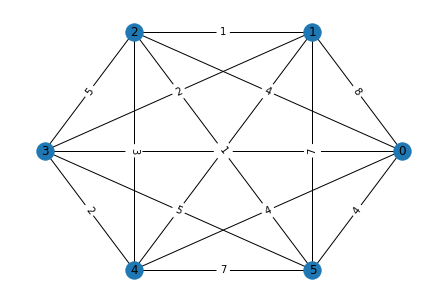

In [ ]:
viaje,distancia=algoritmo_genetico(numero_ciudades,probabilidad)

In [ ]:
viaje

[3, 2, 0, 5, 1, 4]

In [ ]:
distancia

14

In [ ]:
viaje

[1, 5, 2, 3, 4, 0]

In [ ]:
distancia

18